# 📓 Notebook - Teori & Praktik Bab 2: Proyek Machine Learning End-to-End

Selamat datang di notebook panduan untuk Bab 2! Bab ini adalah bab yang paling penting untuk memahami alur kerja sebuah proyek Machine Learning dari awal hingga akhir. Di sini, kita akan mempraktikkan setiap langkah yang dijelaskan di buku menggunakan dataset **California Housing Prices**.

## Langkah 1 & 2: Memahami Masalah dan Mengambil Data

**Teori:**
Setiap proyek ML dimulai dengan tujuan bisnis. Untuk proyek ini, tujuannya adalah **membangun model yang dapat memprediksi harga median rumah di sebuah distrik di California** berdasarkan data sensus.

Ini adalah masalah:
- **Supervised Learning**: Karena data kita memiliki label (harga median rumah).
- **Regresi**: Karena kita memprediksi sebuah nilai numerik.
- **Batch Learning**: Karena kita akan melatih model menggunakan semua data yang ada sekaligus.

Kita akan mulai dengan mengambil data dan melihat strukturnya.

In [1]:
# Setup awal: Impor library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib

# Lokasi download data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Fungsi untuk mengunduh dan mengekstrak data."""
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """Fungsi untuk memuat data dari file CSV."""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Jalankan fungsi untuk mendapatkan data
fetch_housing_data()
housing = load_housing_data()

# Lihat 5 baris pertama dari data
print("Data 5 baris pertama:")
housing.head()

Data 5 baris pertama:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_24572\3829092081.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
# Lihat informasi umum tentang data
print("\nInformasi Dataset:")
housing.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Langkah Penting: Membuat Test Set

**Teori  :**
Sebelum kita melakukan eksplorasi data lebih jauh, kita **harus** memisahkan *test set*. Mengapa? Untuk menghindari **data snooping bias**.

Otak kita sangat pandai menemukan pola. Jika kita melihat *test set* terlalu awal, kita mungkin secara tidak sadar menemukan pola di sana dan memilih model yang bekerja baik untuk *test set* tersebut. Akibatnya, saat kita mengevaluasi model di akhir, hasilnya akan terlalu optimis dan tidak mencerminkan performa model di dunia nyata.

Kita akan menggunakan **Stratified Sampling** untuk memastikan *test set* kita representatif.

In [3]:
from sklearn.model_selection import train_test_split

# Pertama, buat kategori pendapatan untuk stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

# Lakukan stratified split berdasarkan kategori pendapatan
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

# Hapus kolom 'income_cat' agar data kembali seperti semula
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f"Ukuran Training Set: {len(strat_train_set)}")
print(f"Ukuran Test Set: {len(strat_test_set)}")

# Mulai sekarang, kita hanya akan bekerja dengan 'strat_train_set'.
# Kita akan "melupakan" 'strat_test_set' sampai akhir.

Ukuran Training Set: 16512
Ukuran Test Set: 4128


## Langkah 3: Menjelajahi dan Memvisualisasikan Data

**Teori  :**
Tujuan dari fase ini adalah untuk mendapatkan *insight* atau pemahaman mendalam tentang data. Dengan visualisasi, kita bisa menemukan korelasi, pola, dan anomali yang mungkin tidak terlihat dari sekadar melihat angka.

Kita akan membuat beberapa plot untuk memahami distribusi geografis dan hubungan antar fitur.

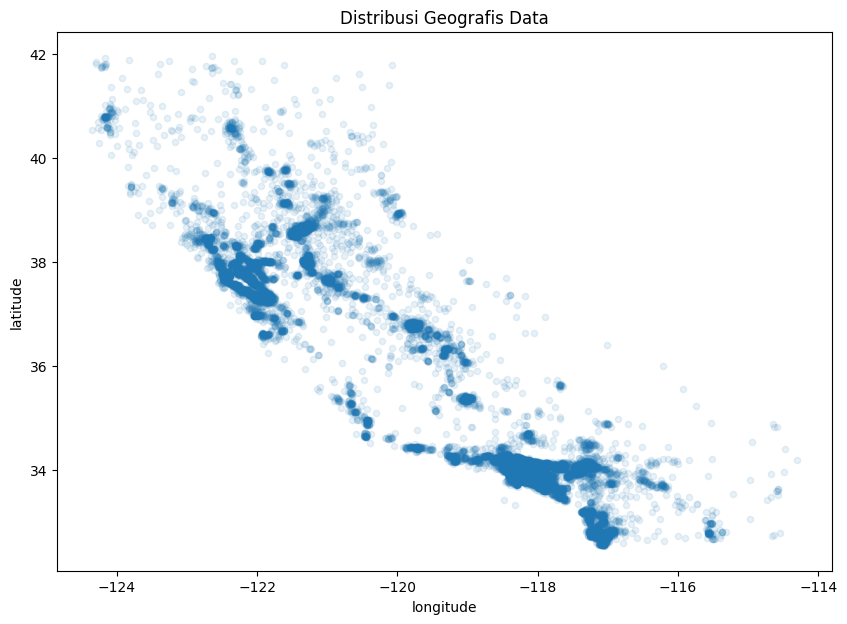

In [4]:
# Buat salinan training set agar data asli tidak termodifikasi
housing = strat_train_set.copy()

# Visualisasi geografis
# Parameter 'alpha=0.1' membantu melihat area padat penduduk
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,7))
plt.title("Distribusi Geografis Data")
plt.show()

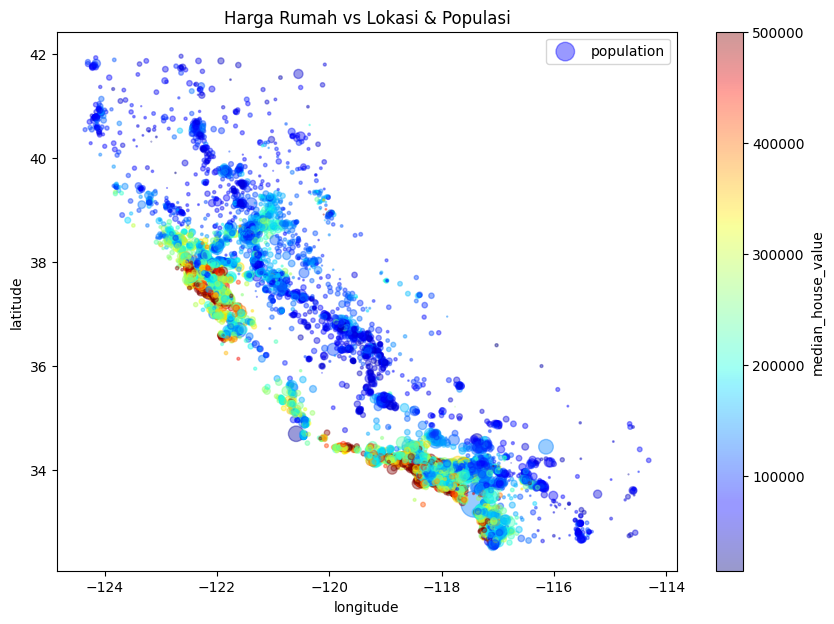

In [5]:
# Visualisasi harga rumah (warna) dan populasi (ukuran)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.title("Harga Rumah vs Lokasi & Populasi")
plt.show()

# Insight: Harga rumah sangat berkaitan dengan lokasi (misalnya, dekat laut) dan kepadatan penduduk.

### Mencari Korelasi

**Teori  :**
Kita bisa menghitung koefisien korelasi standar (Pearson's r) antara setiap pasang atribut. Korelasi berkisar dari -1 (korelasi negatif kuat) hingga 1 (korelasi positif kuat). Nilai mendekati 0 berarti tidak ada korelasi linear.

In [9]:
# Tambahkan numeric_only=True untuk mengabaikan kolom non-numerik
corr_matrix = housing.corr(numeric_only=True)

# Lihat korelasi setiap fitur dengan harga median rumah
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


### Eksperimen dengan Kombinasi Atribut

**Teori  :**
Terkadang, kombinasi beberapa fitur bisa memberikan informasi yang lebih baik daripada fitur-fitur itu sendiri. Ini adalah bagian dari *feature engineering*. Misalnya, jumlah kamar per rumah mungkin lebih informatif daripada total kamar di satu distrik.

In [11]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Insight: Fitur baru 'rooms_per_household' dan 'bedrooms_per_room' ternyata memiliki korelasi yang lebih baik.

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


## Langkah 4: Mempersiapkan Data untuk Algoritma ML

**Teori  :**
Kebanyakan algoritma ML tidak bisa bekerja dengan data yang hilang atau fitur non-numerik. Kita juga perlu memastikan semua fitur memiliki skala yang sama. Proses ini harus diotomatisasi menggunakan fungsi atau *pipeline* agar mudah diterapkan pada data baru.

Kita akan melakukan:
1. **Data Cleaning**: Mengisi nilai yang hilang.
2. **Handling Text/Categorical**: Mengubah fitur teks menjadi angka.
3. **Feature Scaling**: Menyamakan skala semua fitur numerik.
4. **Transformation Pipelines**: Menggabungkan semua langkah menjadi satu.

In [12]:
# Pisahkan kembali fitur (predictors) dan label (target)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Pisahkan fitur numerik dan kategorikal
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

In [13]:
# 1. Data Cleaning: Mengisi nilai null dengan median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num) # imputer belajar median dari data numerik
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

# 2. Handling Categorical: Menggunakan OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print("Fitur kategorikal setelah di-encode (sparse matrix):")
print(housing_cat_1hot.toarray()[:5])

Fitur kategorikal setelah di-encode (sparse matrix):
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


### Transformation Pipelines

**Teori  :**
Scikit-Learn menyediakan `Pipeline` untuk merangkai beberapa langkah transformasi secara berurutan. Ini sangat berguna untuk menjaga kode tetap rapi dan mengurangi risiko kesalahan. `ColumnTransformer` memungkinkan kita menerapkan pipeline yang berbeda untuk kolom yang berbeda (misalnya, numerik dan kategorikal).

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline untuk fitur numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# ColumnTransformer untuk menggabungkan semua transformasi
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Jalankan pipeline pada data housing
housing_prepared = full_pipeline.fit_transform(housing)

print("Shape data setelah diproses:", housing_prepared.shape)
print("Data siap digunakan untuk melatih model!")

Shape data setelah diproses: (16512, 13)
Data siap digunakan untuk melatih model!


## Langkah 5: Memilih dan Melatih Model

**Teori  :**
Sekarang data kita sudah bersih dan siap pakai. Saatnya melatih beberapa model. Sebaiknya kita mulai dari model yang sederhana, seperti Regresi Linier, lalu coba model yang lebih kompleks.

Kita akan mengukur performa menggunakan **Root Mean Square Error (RMSE)**. Semakin kecil RMSE, semakin baik modelnya.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Evaluasi pada training set
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"RMSE Regresi Linier pada Training Set: {lin_rmse:.2f}")

# Insight: Error sekitar $68,628. Ini cukup besar, artinya model ini underfitting.

RMSE Regresi Linier pada Training Set: 69050.56


In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"RMSE Decision Tree pada Training Set: {tree_rmse:.2f}")

# Insight: Error 0.0! Ini adalah tanda jelas bahwa model ini overfitting.

RMSE Decision Tree pada Training Set: 0.00


### Evaluasi yang Lebih Baik Menggunakan Cross-Validation

**Teori  :**
Karena model *Decision Tree* overfitting, kita butuh cara evaluasi yang lebih baik. **K-fold Cross-Validation** adalah solusinya. Ia membagi training set menjadi beberapa bagian (misalnya 10), lalu melatih dan mengevaluasi model 10 kali, setiap kali menggunakan bagian yang berbeda sebagai set validasi. Ini memberikan estimasi performa yang lebih stabil.

In [17]:
from sklearn.model_selection import cross_val_score

# Scikit-learn cross-validation mengharapkan fungsi utility (semakin besar semakin baik),
# bukan fungsi loss (semakin kecil semakin baik), jadi kita gunakan 'neg_mean_squared_error'
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

# Insight: Rata-rata errornya sekitar $71,200. Ini jauh lebih buruk dari Regresi Linier. Decision Tree jelas overfitting.

Scores: [70143.05390798 68678.99042967 64854.85624715 69259.05580195
 67233.88757945 69052.2887905  72330.20840317 69966.98220548
 68171.33982929 71053.9649082 ]
Mean: 69074.46281028344
Standard deviation: 1966.1174490983092


## Langkah 6: Fine-Tune Model

**Teori  :**
Setelah memilih beberapa model yang menjanjikan (misalnya, `RandomForestRegressor`), kita perlu mencari kombinasi *hyperparameter* terbaik. Mencoba satu per satu secara manual sangat melelahkan. **Grid Search** adalah teknik untuk mengotomatiskan proses ini. Ia akan mencoba semua kombinasi hyperparameter yang kita berikan dan menemukan yang terbaik melalui cross-validation.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Tentukan kombinasi hyperparameter yang ingin dicoba
# Peringatan: Proses ini bisa memakan waktu cukup lama!
# Kita gunakan sedikit kombinasi agar cepat.
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

print("Hyperparameter terbaik:", grid_search.best_params_)

# Lihat skor terbaik
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"RMSE terbaik dari Grid Search: {best_rmse:.2f}")

Hyperparameter terbaik: {'max_features': 8, 'n_estimators': 30}
RMSE terbaik dari Grid Search: 50106.09


## Langkah 7: Evaluasi Final pada Test Set

**Teori  :**
Setelah menemukan model terbaik dan hyperparameter-nya, inilah saatnya kita melihat performa finalnya pada *test set* yang selama ini kita simpan. Hasil ini akan menjadi estimasi terbaik kita tentang bagaimana model akan bekerja pada data baru di dunia nyata.

In [19]:
final_model = grid_search.best_estimator_

# Pisahkan fitur dan label dari test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Jalankan test set melalui pipeline (HANYA transform, JANGAN fit!)
X_test_prepared = full_pipeline.transform(X_test)

# Buat prediksi final
final_predictions = final_model.predict(X_test_prepared)

# Hitung RMSE final
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"RMSE Final pada Test Set: {final_rmse:.2f}")

RMSE Final pada Test Set: 47822.10


## Kesimpulan

Berikut adalah alur kerja proyek Machine Learning:
1. Memahami masalah
2. Mengambil data
3. Membuat *test set* yang representatif
4. Mengeksplorasi data untuk mencari *insight*
5. Mempersiapkan data secara otomatis dengan *pipeline*
6. Melatih beberapa model dan memilih yang terbaik
7. Melakukan *fine-tuning* hyperparameter
8. Mengevaluasi model final pada *test set*
